# Johdantu Datatieteeseen harjoitustyö

Tarkoituksena on selvittää vaikutusta hintaan sen mukaan. Valittuja muuttujia ovat asunnon etäisyys Eiffel tornista, kaupunginosan metroasemien lkm tai millä puolella jokea asunto sijaitsee.

Etäisyys Eiffel-tornista voidaan laskea annettujen koordinaattien mukaan käyttäen haversine-funktiota. 

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import linear_model

LISTINGSFILE = 'listings.csv'

cols = ['latitude', 'longitude', 'price', 'neighbourhood_cleansed']

df = pd.read_csv(LISTINGSFILE, usecols=cols)

len(df.index)

59945

In [9]:
df.head(5)

,neighbourhood_cleansed,latitude,longitude,price
0,Observatoire,48.833494,2.318518,$59.00
1,Hôtel-de-Ville,48.851001,2.358690,$93.00
2,Hôtel-de-Ville,48.857576,2.352751,$110.00
3,Ménilmontant,48.865279,2.393263,$90.00
4,Vaugirard,48.853003,2.286014,$371.00


In [12]:
df.neighbourhood_cleansed.unique()

array(['Observatoire', 'Hôtel-de-Ville', 'Ménilmontant', 'Vaugirard',
       'Popincourt', 'Buttes-Montmartre', 'Élysée', 'Panthéon',
       'Entrepôt', 'Buttes-Chaumont', 'Gobelins', 'Temple', 'Opéra',
       'Luxembourg', 'Louvre', 'Palais-Bourbon', 'Reuilly',
       'Batignolles-Monceau', 'Bourse', 'Passy'], dtype=object)

In [43]:
nhoods = [('Observatoire', 14, 'Left', 13),
('Hôtel-de-Ville', 4, 'Right', 9),
('Ménilmontant', 20, 'Right', 19),
('Vaugirard', 15, 'Left', 22),
('Popincourt', 11, 'Right', 25),
('Buttes-Montmartre', 18, 'Right', 18),
('Élysée', 8, 'Right', 19),
('Panthéon', 5, 'Left', 8),
('Entrepôt', 10, 'Right', 17),
('Buttes-Chaumont', 19, 'Right', 22),
('Gobelins', 13, 'Left', 18),
('Temple', 3, 'Right', 9),
('Opéra', 9, 'Right', 19),
('Luxembourg', 6, 'Left', 14),
('Louvre', 1, 'Right', 9),
('Palais-Bourbon', 7, 'Left', 13),
('Reuilly', 12, 'Right', 19),
('Batignolles-Monceau', 17, 'Right', 18),
('Bourse', 2, 'Right', 10),
('Passy', 16, 'Right', 23)]
labels = ['neighbourhood_cleansed', 'arrondissement', 'river_bank_side', 'metro_stations']
df_metro = pd.DataFrame.from_records(nhoods, columns=labels)
df_metro.head()

,neighbourhood_cleansed,arrondissement,river_bank_side,metro_stations
0,Observatoire,14,Left,13
1,Hôtel-de-Ville,4,Right,9
2,Ménilmontant,20,Right,19
3,Vaugirard,15,Left,22
4,Popincourt,11,Right,25


In [44]:
df_metro.neighbourhood_cleansed.unique()

array(['Observatoire', 'Hôtel-de-Ville', 'Ménilmontant', 'Vaugirard',
       'Popincourt', 'Buttes-Montmartre', 'Élysée', 'Panthéon',
       'Entrepôt', 'Buttes-Chaumont', 'Gobelins', 'Temple', 'Opéra',
       'Luxembourg', 'Louvre', 'Palais-Bourbon', 'Reuilly',
       'Batignolles-Monceau', 'Bourse', 'Passy'], dtype=object)

Yhdistetään wikipedian avulla täydennetty ja tehty dataframe, jossa on eri 'neighbourhood_cleansed' arvoja vastaavat kaupunginosan numero, millä puolella jokea sijaitsee sekä metroasemien lukumäärä, alkuperäisen dataframen kanssa.

In [20]:
df_joined = df.join(df_metro.set_index('neighbourhood_cleansed'), on='neighbourhood_cleansed')
df_joined.head()

,neighbourhood_cleansed,latitude,longitude,price,arrondissement,river_bank_side,metro_stations
0,Observatoire,48.833494,2.318518,$59.00,14.0,Left,13.0
1,Hôtel-de-Ville,48.851001,2.358690,$93.00,4.0,Right,9.0
2,Hôtel-de-Ville,48.857576,2.352751,$110.00,4.0,Right,9.0
3,Ménilmontant,48.865279,2.393263,$90.00,20.0,Right,19.0
4,Vaugirard,48.853003,2.286014,$371.00,15.0,Left,22.0


Tarkistetaan tuliko virheitä etsimällä tyhjien arvojen lukumäärä. Tyhjiä arvoja löytyi.

In [32]:
df_joined.isnull().sum().sum()

4578

Katsotaan millä sarakkeilla esiintyvät. Huomataan, että ne esiintyy juurikin joinissa käytetyn toisen dataframen puolella.

In [33]:
df_joined.isnull().any()

neighbourhood_cleansed    False
latitude                  False
longitude                 False
price                     False
arrondissement             True
river_bank_side            True
metro_stations             True
dtype: bool

Haetaan columnin mukaan tyhjiä rivejä ja otetaan ne talteen. Sen jälkeen katsotaan niiden arvoja. Huomataan, että ne tapahtuu 'Élysée':n kohdalla. Tarkistin df_metro-dataframen luonnissa käytetyt tiedot ja sieltä löyty ylimääräinen merkki 'Élysée'-nimestä, minkä takia yhdistäminen sen kohdalla epäonnistui.

In [34]:
nan_rows = df_joined[df_joined['arrondissement'].isnull()]
nan_rows.head()

,neighbourhood_cleansed,latitude,longitude,price,arrondissement,river_bank_side,metro_stations
9,Élysée,48.879001,2.316083,$90.00,NaN,NaN,NaN
58,Élysée,48.879525,2.305434,$76.00,NaN,NaN,NaN
83,Élysée,48.879144,2.326873,$60.00,NaN,NaN,NaN
135,Élysée,48.872042,2.309664,$220.00,NaN,NaN,NaN
152,Élysée,48.872043,2.314211,$310.00,NaN,NaN,NaN


In [45]:
df_joinedfix = df.join(df_metro.set_index('neighbourhood_cleansed'), on='neighbourhood_cleansed')
df_joinedfix.isnull().any()

neighbourhood_cleansed    False
latitude                  False
longitude                 False
price                     False
arrondissement            False
river_bank_side           False
metro_stations            False
dtype: bool

Lisätään uusi sarake, johonka on laskettu etäisyys Eiffel-tornista. Voisi jopa lisätä 4:n suosituimman nähtävyyden etäisyydet. https://www.tripadvisor.fi/Attractions-g187147-Activities-Paris_Ile_de_France.html

Haversine funktio: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [54]:
e_lon = 2.294481
e_lat = 48.858370

from math import radians, cos, sin, asin, sqrt

def haversine(row):
    lon1 = e_lon
    lat1 = e_lat
    lon2 = row['longitude']
    lat2 = row['latitude']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    meters = km*1000
    return meters
df_joinedfix['distance_from_eiffel'] = df_joinedfix.apply(lambda row: haversine(row), axis=1)
df_joinedfix.head()

,neighbourhood_cleansed,latitude,longitude,price,arrondissement,river_bank_side,metro_stations,distance_from_eiffel
0,Observatoire,48.833494,2.318518,$59.00,14,Left,13,3275.932594
1,Hôtel-de-Ville,48.851001,2.358690,$93.00,4,Right,9,4765.693329
2,Hôtel-de-Ville,48.857576,2.352751,$110.00,4,Right,9,4261.190668
3,Ménilmontant,48.865279,2.393263,$90.00,20,Right,19,7262.353616
4,Vaugirard,48.853003,2.286014,$371.00,15,Left,22,859.608657


Poistetaan dollarin merkit ja laitetaan tilalle float arvo.

In [57]:
df_joinedfix['price'] = df_joinedfix['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
df_joinedfix.head(5)

,neighbourhood_cleansed,latitude,longitude,price,arrondissement,river_bank_side,metro_stations,distance_from_eiffel
0,Observatoire,48.833494,2.318518,59.0,14,Left,13,3275.932594
1,Hôtel-de-Ville,48.851001,2.358690,93.0,4,Right,9,4765.693329
2,Hôtel-de-Ville,48.857576,2.352751,110.0,4,Right,9,4261.190668
3,Ménilmontant,48.865279,2.393263,90.0,20,Right,19,7262.353616
4,Vaugirard,48.853003,2.286014,371.0,15,Left,22,859.608657


In [56]:
df_joinedfix.isnull().any()

neighbourhood_cleansed    False
latitude                  False
longitude                 False
price                     False
arrondissement            False
river_bank_side           False
metro_stations            False
distance_from_eiffel      False
dtype: bool

Muutetaan 'river_bank_side'-sarakkeen 'Left' ja 'Right' arvot 'valearvoiksi' (engl. dummy). Tehdään myös sama 'neighbourhood_cleansed'-sarakkeelle.

In [63]:
river_dummies = pd.get_dummies(df_joinedfix.river_bank_side, prefix='river_side')
neigh_dummies = pd.get_dummies(df_joinedfix.neighbourhood_cleansed)
finaldata = pd.concat((df_joinedfix.drop(['neighbourhood_cleansed', \
    'river_bank_side'], axis=1), neigh_dummies.astype(int), \
    river_dummies.astype(int)), axis=1)
finalcols = finaldata.columns
finaldata.head(5)

,latitude,longitude,price,arrondissement,metro_stations,distance_from_eiffel,Batignolles-Monceau,Bourse,Buttes-Chaumont,Buttes-Montmartre,...,Palais-Bourbon,Panthéon,Passy,Popincourt,Reuilly,Temple,Vaugirard,Élysée,river_side_Left,river_side_Right
0,48.833494,2.318518,59.0,14,13,3275.932594,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,48.851001,2.358690,93.0,4,9,4765.693329,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,48.857576,2.352751,110.0,4,9,4261.190668,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,48.865279,2.393263,90.0,20,19,7262.353616,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,48.853003,2.286014,371.0,15,22,859.608657,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


Scatter plotista ei löydetä oikeastaan mitään kiinnostavaa. Ainoa asia, mitä siitä havaitaan on 'arrondissement':n ja 'metro_stations':n yhteys. Kaupunginosassa on siis tietty määrä metroasemia.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f625205cda0>,
      dtype=object)

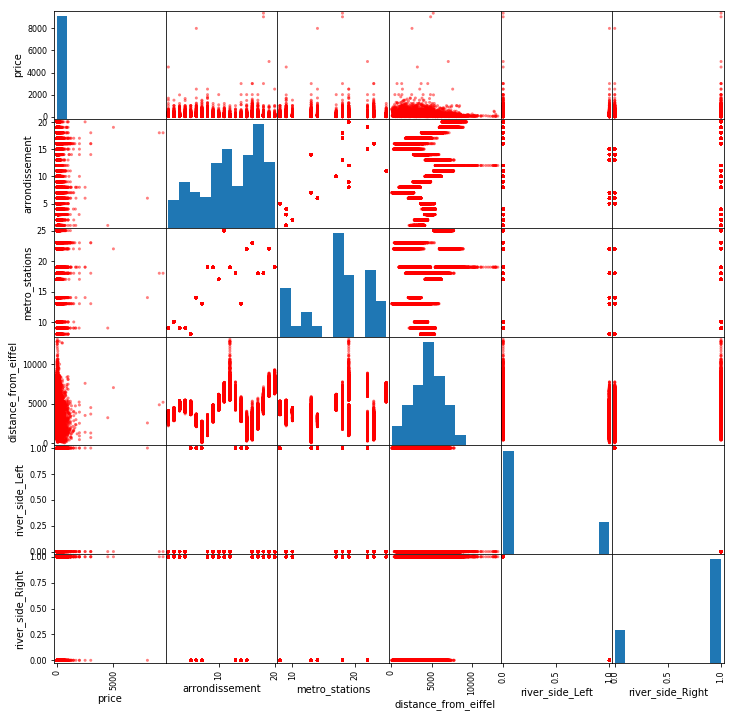

In [71]:
from pandas.plotting import scatter_matrix

scattercols = ['price','arrondissement', 'metro_stations', 'distance_from_eiffel', 'river_side_Left', 'river_side_Right']
scatter_matrix(finaldata[scattercols], figsize=(12, 12), c='red')